In [1]:
import numpy
from matplotlib import pyplot
import os

In [2]:
basedir = "markov_data"

In [3]:
data = {}

for file in os.listdir(basedir):
    if file.endswith(".npz"):
        arr = numpy.load(os.path.join(basedir, file))
        L = arr["L"][()]
        if L not in data:
            data[L] = []
        data[L].append({key: arr[key] for key in arr._files})

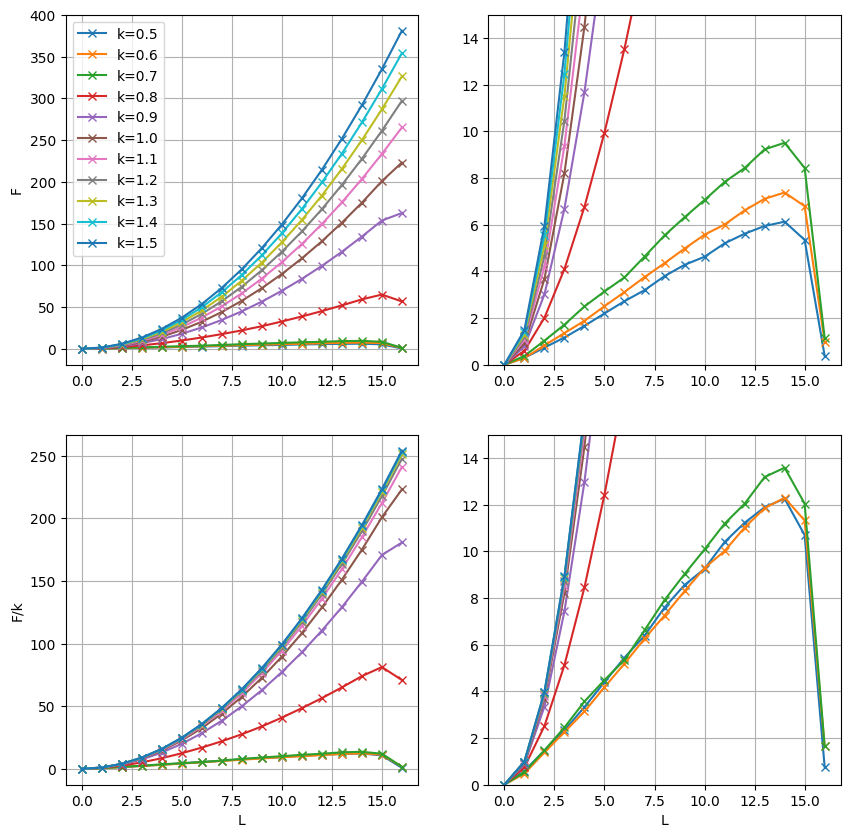

In [4]:
fig, axs = pyplot.subplots(2,2, figsize=(10,10))

L = 16
for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,0].plot([d["free_energy"][i*i] for i in range(L+1)], "x-", label=f"k={k:.1f}")
axs[0,0].grid()
axs[0,0].legend()
axs[0,0].set_ylabel("F")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,0].plot([d["free_energy"][i*i] / k for i in range(L+1)], "x-", label=f"k={k:.1f}")
axs[1,0].grid()
axs[1,0].set_xlabel("L")
axs[1,0].set_ylabel("F/k")

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[0,1].plot([d["free_energy"][i*i] for i in range(L+1)], "x-", label=f"k={k:.1f}")
axs[0,1].grid()
axs[0,1].set_ylim([0,15])

for d in sorted(data[L], key=lambda d: d["k"][()]):
    k = d["k"][()]
    axs[1,1].plot([d["free_energy"][i*i] / k for i in range(L+1)], "x-", label=f"k={k:.1f}")
axs[1,1].grid()
axs[1,1].set_ylim([0,15])
axs[1,1].set_xlabel("L")

pyplot.savefig("free_energy_flows.png")
pyplot.show()